In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse 
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from utils import accuracy
from models.gcn_original import GCN2
from models.my_gcn import myGCN2
from models.mlp import mlp2
import pickle

/home/lxt/anaconda3/envs/gnn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch_geometric.datasets import Planetoid, Amazon, Actor, WebKB, Coauthor, WikiCS

In [3]:
dataset_name = 'Cora'
dataset = Planetoid(root='/home/lxt/data/Planetoid', name=dataset_name)
data = dataset[0]
features = data.x.cuda()
labels = data.y.cuda()
edge_index = data.edge_index.cuda()
idx_train = torch.where(data.train_mask)[0].cuda()
idx_val = torch.where(data.val_mask)[0].cuda()
idx_test = torch.where(data.test_mask)[0].cuda()
C = labels.max().item() + 1
label_train = labels[idx_train]
label_valid = labels[idx_val]
label_test = labels[idx_test]

In [4]:
print(features.shape)
print(labels.max().item() + 1)

torch.Size([2708, 1433])
7


In [9]:
class graphs():
    def __init__(self):
        self.accuracy     = []
        self.loss         = []
        self.reg_loss     = []

        # NC1: Sw -> within-class covariance, Sb -> between-class covariance
        self.Sw_invSb     = []
        self.avg_dis      = []
        self.tr_Sw      = []

        # NC2 : M -> class means; W: classifiers
        self.norm_M_CoV   = []
        self.norm_W_CoV   = []
        self.cos_M        = []
        self.cos_W        = []
        self.degree_M     = []
        self.degree_W     = []
        self.norm_M_avg   = []
        self.norm_W_avg   = []
        self.norm_W_std   = []

        # NC3
        self.W_M_dist     = []
        
        # NC4: Nearest Class Center
        self.NCC_mismatch = []

        # Decomposition
        self.MSE_wd_features = []
        self.LNC1 = []
        self.LNC23 = []
        self.Lperp = []

In [6]:
from collapse_analysis import graphNC
def train(epoch, model, optimizer, graph_train, graph_test):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    if 'mlp' in str(model):
        embedding, output =  model(features)
    else:
        embedding, output =  model(features, edge_index)
    embed_train = embedding[idx_train].detach()
    embed_valid = embedding[idx_val].detach()
    embed_test = embedding[idx_test].detach()
    output_train = output[idx_train].detach()
    output_valid = output[idx_val].detach()
    output_test = output[idx_test].detach()
    cls = model.cls
    graphNC(embed_train, label_train, output_train, C, cls, graph_train)
    graphNC(embed_test, label_test, output_test, C, cls, graph_test)
    # print(output.size())
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    if epoch % 10 == 0:
      print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val.item()),
            'time: {:.4f}s'.format(time.time() - t))
    return embedding

In [7]:
def test(model):
    model.eval()
    if 'mlp' in str(model):
        embedding, output =  model(features)
    else:
        embedding, output =  model(features, edge_index)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [10]:
hidden = 128
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
model = myGCN2(nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
model.cuda()
gcn_train = graphs()
gcn_test = graphs()
t_total = time.time()
for epoch in range(200):
    embedding = train(epoch, model, optimizer, gcn_train, gcn_test)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
pickle.dump(embedding, open('./nc_stats/cora_gcn_embeddings.pkl', 'wb'))
test(model)

Epoch: 0001 loss_train: 1.9455 acc_train: 0.1429 loss_val: 1.9412 acc_val: 0.1180 time: 0.2406s
Epoch: 0011 loss_train: 0.0057 acc_train: 1.0000 loss_val: 0.9386 acc_val: 0.7640 time: 0.1863s
Epoch: 0021 loss_train: 0.0576 acc_train: 0.9857 loss_val: 2.1156 acc_val: 0.7280 time: 0.1669s
Epoch: 0031 loss_train: 0.0160 acc_train: 0.9929 loss_val: 2.0033 acc_val: 0.7620 time: 0.2401s
Epoch: 0041 loss_train: 0.0003 acc_train: 1.0000 loss_val: 1.8143 acc_val: 0.7740 time: 0.2244s
Epoch: 0051 loss_train: 0.0011 acc_train: 1.0000 loss_val: 1.6451 acc_val: 0.7400 time: 0.2021s
Epoch: 0061 loss_train: 0.0019 acc_train: 1.0000 loss_val: 1.3570 acc_val: 0.7440 time: 0.2060s
Epoch: 0071 loss_train: 0.0022 acc_train: 1.0000 loss_val: 1.0982 acc_val: 0.7400 time: 0.1713s
Epoch: 0081 loss_train: 0.0030 acc_train: 1.0000 loss_val: 1.0243 acc_val: 0.7560 time: 0.2080s
Epoch: 0091 loss_train: 0.0033 acc_train: 1.0000 loss_val: 0.9842 acc_val: 0.7440 time: 0.1731s
Epoch: 0101 loss_train: 0.0041 acc_train

In [11]:
import pickle
pickle.dump(gcn_train, open('./nc_stats/gcn_train.pkl', 'wb'))
pickle.dump(gcn_test, open('./nc_stats/gcn_test.pkl', 'wb'))


In [12]:
hidden = 128
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
model = mlp2(nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
model.cuda()
mlp_train = graphs()
mlp_test = graphs()
t_total = time.time()
for epoch in range(200):
    embedding = train(epoch, model, optimizer, mlp_train, mlp_test)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
test(model)
pickle.dump(embedding, open('./nc_stats/cora_mlp_embeddings.pkl', 'wb'))

Epoch: 0001 loss_train: 1.9486 acc_train: 0.1429 loss_val: 1.9368 acc_val: 0.1600 time: 0.1932s
Epoch: 0011 loss_train: 0.0170 acc_train: 1.0000 loss_val: 1.8826 acc_val: 0.5060 time: 0.2098s
Epoch: 0021 loss_train: 0.0001 acc_train: 1.0000 loss_val: 5.0438 acc_val: 0.4800 time: 0.2003s
Epoch: 0031 loss_train: 0.0051 acc_train: 0.9929 loss_val: 5.5066 acc_val: 0.4880 time: 0.1602s
Epoch: 0041 loss_train: 0.0011 acc_train: 1.0000 loss_val: 5.6699 acc_val: 0.4620 time: 0.1960s
Epoch: 0051 loss_train: 0.0821 acc_train: 0.9786 loss_val: 5.1756 acc_val: 0.4700 time: 0.1500s
Epoch: 0061 loss_train: 0.0296 acc_train: 0.9929 loss_val: 3.6958 acc_val: 0.5160 time: 0.1863s
Epoch: 0071 loss_train: 0.0008 acc_train: 1.0000 loss_val: 3.2301 acc_val: 0.4780 time: 0.2515s
Epoch: 0081 loss_train: 0.0017 acc_train: 1.0000 loss_val: 2.7718 acc_val: 0.5240 time: 0.1533s
Epoch: 0091 loss_train: 0.0016 acc_train: 1.0000 loss_val: 2.4662 acc_val: 0.5040 time: 0.1650s
Epoch: 0101 loss_train: 0.0212 acc_train

In [14]:
pickle.dump(mlp_train, open('./nc_stats/mlp_train.pkl', 'wb'))
pickle.dump(mlp_test, open('./nc_stats/mlp_test.pkl', 'wb'))

In [15]:
print(embedding.size())
print(torch.norm(embedding[idx_train], dim=1).mean())

torch.Size([2708, 128])
tensor(9.0622, device='cuda:0', grad_fn=<MeanBackward0>)


In [16]:
def cls_num(label):
    l = label.cpu().numpy().tolist()
    res = {}
    for c in l:
        res[c] = res.get(c, 0) + 1
    return res

In [17]:
label_train = labels[idx_train]
label_valid = labels[idx_val]
label_test = labels[idx_test]
cls_num_train = cls_num(label_train)
print('train class number list:', cls_num_train)
cls_num_valid = cls_num(label_valid)
print('valid class number list:', cls_num_valid)
cls_num_test = cls_num(label_test)
print('test class number list:', cls_num_test)

train class number list: {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
valid class number list: {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
test class number list: {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


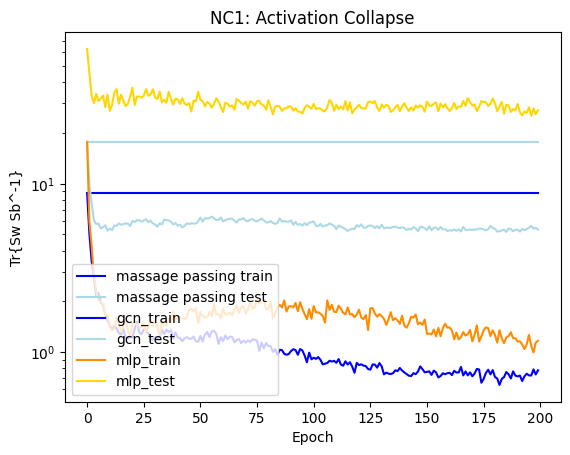

In [28]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.semilogy(range(200), [gcn_train.Sw_invSb[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test.Sw_invSb[0]] * 200, label='massage passing test', color='lightblue')
plt.semilogy(range(200), gcn_train.Sw_invSb, label='gcn_train', color='blue')
plt.semilogy(range(200), gcn_test.Sw_invSb, label='gcn_test', color='lightblue')
plt.semilogy(range(200), mlp_train.Sw_invSb, label='mlp_train', color='darkorange')
plt.semilogy(range(200), mlp_test.Sw_invSb, label='mlp_test', color='gold')
# plt.plot(range(190), gcn_train.Sw_invSb[10:], label='gcn_train', color='blue')
# plt.plot(range(190), gcn_test.Sw_invSb[10:], label='gcn_test', color='lightblue')
# plt.plot(range(190), mlp_train.Sw_invSb[10:], label='mlp_train', color='darkorange')
# plt.plot(range(190), mlp_test.Sw_invSb[10:], label='mlp_test', color='gold')
# plt.legend(['train', 'valid'])
plt.xlabel('Epoch')
plt.ylabel('Tr{Sw Sb^-1}')
plt.title('NC1: Activation Collapse')
plt.legend()

Text(0.5, 1.0, 'NC1: Activation Collapse')

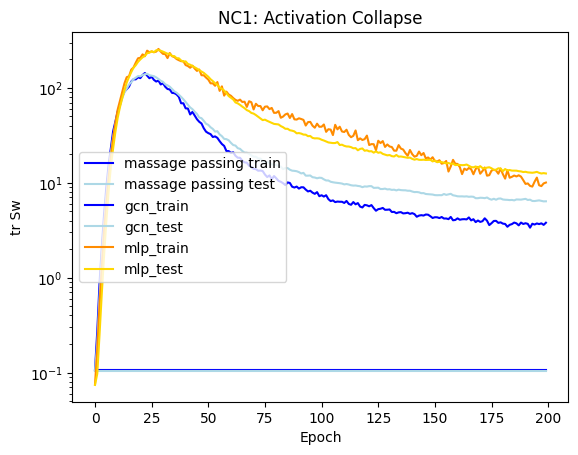

In [29]:
plt.figure(2)
plt.semilogy(range(200), [gcn_train.tr_Sw[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test.tr_Sw[0]] * 200, label='massage passing test', color='lightblue')
plt.semilogy(range(200), gcn_train.tr_Sw, label='gcn_train', color='blue')
plt.semilogy(range(200), gcn_test.tr_Sw, label='gcn_test', color='lightblue')
plt.semilogy(range(200), mlp_train.tr_Sw, label='mlp_train', color='darkorange')
plt.semilogy(range(200), mlp_test.tr_Sw, label='mlp_test', color='gold')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('tr Sw')
plt.title('NC1: Activation Collapse')

Text(0.5, 1.0, 'NC2: Maximum seperation')

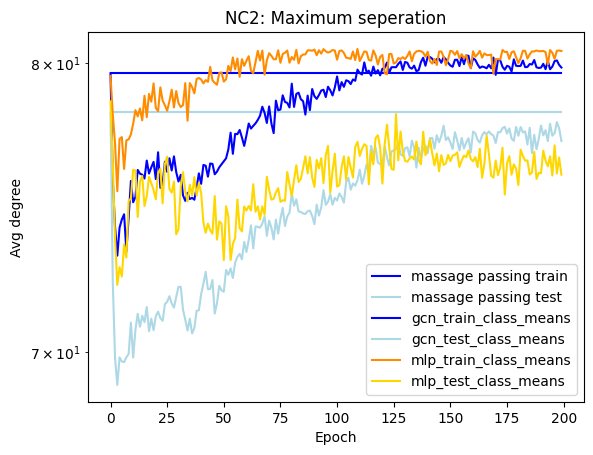

In [31]:
plt.figure(3)
plt.semilogy(range(200), [gcn_train.degree_M[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test.degree_M[0]] * 200, label='massage passing test', color='lightblue')
plt.plot(range(200), gcn_train.degree_M, label='gcn_train_class_means', color='blue')
plt.plot(range(200), gcn_test.degree_M, label='gcn_test_class_means', color='lightblue')
plt.plot(range(200), mlp_train.degree_M, label='mlp_train_class_means', color='darkorange')
plt.plot(range(200), mlp_test.degree_M, label='mlp_test_class_means', color='gold')
plt.legend()
# plt.legend(['Class Means','Classifiers'])
plt.xlabel('Epoch')
plt.ylabel('Avg degree')
plt.title('NC2: Maximum seperation')

Text(0.5, 1.0, 'NC2: Equinorm')

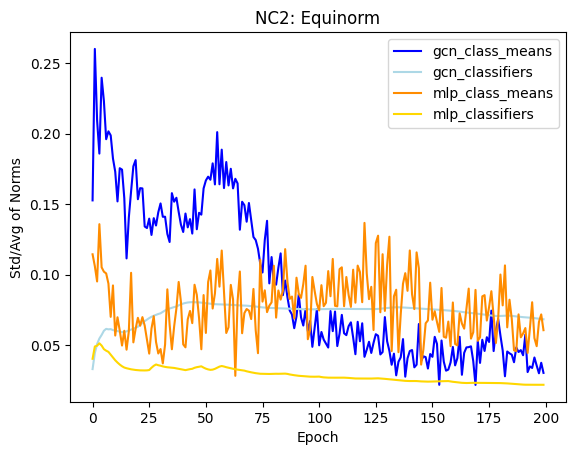

In [32]:
plt.figure(4)
plt.plot(range(200), gcn_train.norm_M_CoV, label='gcn_class_means', color='blue')
plt.plot(range(200), gcn_test.norm_W_CoV, label='gcn_classifiers', color='lightblue')
plt.plot(range(200), mlp_train.norm_M_CoV, label='mlp_class_means', color='darkorange')
plt.plot(range(200), mlp_test.norm_W_CoV, label='mlp_classifiers', color='gold')
plt.legend()
# plt.legend(['Class Means','Classifiers'])
plt.xlabel('Epoch')
plt.ylabel('Std/Avg of Norms')
plt.title('NC2: Equinorm')

Text(0.5, 1.0, 'NC2: Maximal Equiangularity')

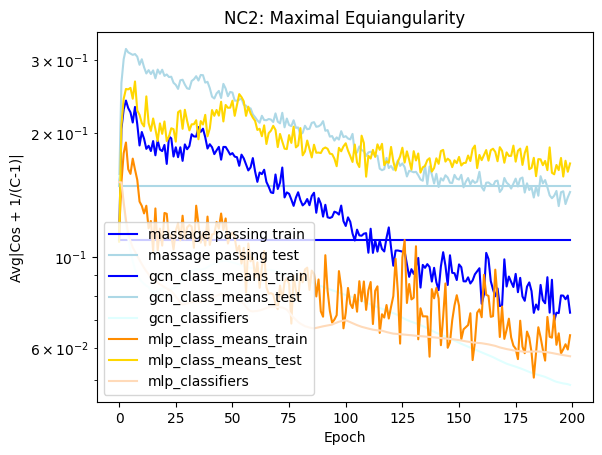

In [41]:
plt.figure(5)
plt.semilogy(range(200), [gcn_train.cos_M[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test.cos_M[0]] * 200, label='massage passing test', color='lightblue')
plt.plot(range(200), gcn_train.cos_M, label='gcn_class_means_train', color='blue')
plt.plot(range(200), gcn_test.cos_M, label='gcn_class_means_test', color='lightblue')
plt.plot(range(200), gcn_train.cos_W, label='gcn_classifiers', color='lightcyan')
plt.plot(range(200), mlp_train.cos_M, label='mlp_class_means_train', color='darkorange')
plt.plot(range(200), mlp_test.cos_M, label='mlp_class_means_test', color='gold')
plt.plot(range(200), mlp_train.cos_W, label='mlp_classifiers', color='peachpuff')
plt.legend(loc='lower left')
plt.xlabel('Epoch')
plt.ylabel('Avg|Cos + 1/(C-1)|')
plt.title('NC2: Maximal Equiangularity')
### -1/7-1 = -0.16667

In [42]:
dataset_name = 'Cora'
dataset = Planetoid(root='/home/lxt/data/Planetoid', name=dataset_name)
data = dataset[0]
features = data.x.cuda()
labels = data.y.cuda()
edge_index = data.edge_index.cuda()
# idx_train = torch.where(data.train_mask)[0].cuda()
# idx_val = torch.where(data.val_mask)[0].cuda()
# idx_test = torch.where(data.test_mask)[0].cuda()
C = labels.max().item() + 1

In [43]:
import random
from data.data_loader import get_step_split
from types import SimpleNamespace
opt = SimpleNamespace()
opt.imb_ratio = 5.
opt.valid_each = 30
opt.head_list = [0, 1, 2]
opt.labeling_ratio = 0.05

shuffle_seed = 42
mask_list = [i for i in range(data.num_nodes)]
random.seed(shuffle_seed)
random.shuffle(mask_list)
idx_train, idx_valid, idx_test, train_node = get_step_split(opt, mask_list, data.y.numpy(), nclass=C)

3 4
135.4
7
[0, 1, 2]
0
1
2
train size: 105


In [44]:
print(len(idx_train), len(idx_valid), len(idx_test))

133 210 2365


In [45]:
label_train = labels[idx_train]
label_valid = labels[idx_val]
label_test = labels[idx_test]
cls_num_train = cls_num(label_train)
print('train class number list:', cls_num_train)
cls_num_valid = cls_num(label_valid)
print('valid class number list:', cls_num_valid)
cls_num_test = cls_num(label_test)
print('test class number list:', cls_num_test)

train class number list: {6: 7, 3: 7, 2: 35, 0: 35, 4: 7, 5: 7, 1: 35}
valid class number list: {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
test class number list: {3: 781, 4: 389, 2: 353, 0: 286, 5: 261, 1: 152, 6: 143}


In [46]:
hidden = 128
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
model = myGCN2(nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
model.cuda()
gcn_train_imb = graphs()
gcn_test_imb = graphs()

In [47]:
t_total = time.time()
for epoch in range(200):
    embedding = train(epoch, model, optimizer, gcn_train_imb, gcn_test_imb)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
pickle.dump(embedding, open('./nc_stats/cora_imb_gcn_embeddings.pkl', 'wb'))
test(model)

Epoch: 0001 loss_train: 1.9627 acc_train: 0.1053 loss_val: 1.9462 acc_val: 0.1620 time: 0.4422s


/home/lxt/codes/gnn/collapse_analysis.py:120: RuntimeWarning: divide by zero encountered in reciprocal
  inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T
/home/lxt/codes/gnn/collapse_analysis.py:121: RuntimeWarning: invalid value encountered in matmul
  graphs.Sw_invSb.append(np.trace(Sw @ inv_Sb))
/home/lxt/codes/gnn/collapse_analysis.py:120: RuntimeWarning: invalid value encountered in matmul
  inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T


Epoch: 0011 loss_train: 0.2643 acc_train: 0.9549 loss_val: 1.5411 acc_val: 0.4500 time: 0.2124s
Epoch: 0021 loss_train: 0.0100 acc_train: 1.0000 loss_val: 1.0757 acc_val: 0.7320 time: 0.2151s
Epoch: 0031 loss_train: 0.0795 acc_train: 0.9850 loss_val: 1.7966 acc_val: 0.6300 time: 0.2344s
Epoch: 0041 loss_train: 0.0104 acc_train: 1.0000 loss_val: 1.6463 acc_val: 0.6520 time: 0.2121s
Epoch: 0051 loss_train: 0.0080 acc_train: 1.0000 loss_val: 1.3511 acc_val: 0.6520 time: 0.2128s
Epoch: 0061 loss_train: 0.0131 acc_train: 0.9925 loss_val: 1.3920 acc_val: 0.6060 time: 0.2125s
Epoch: 0071 loss_train: 0.0159 acc_train: 0.9925 loss_val: 1.1812 acc_val: 0.6540 time: 0.2131s
Epoch: 0081 loss_train: 0.0097 acc_train: 1.0000 loss_val: 1.3910 acc_val: 0.6040 time: 0.2118s
Epoch: 0091 loss_train: 0.0053 acc_train: 1.0000 loss_val: 1.4205 acc_val: 0.5840 time: 0.2231s
Epoch: 0101 loss_train: 0.0118 acc_train: 0.9925 loss_val: 1.2490 acc_val: 0.6120 time: 0.2120s
Epoch: 0111 loss_train: 0.0132 acc_train

In [48]:
pickle.dump(gcn_train_imb, open('./nc_stats/gcn_train_imb.pkl', 'wb'))
pickle.dump(gcn_test_imb, open('./nc_stats/gcn_test_imb.pkl', 'wb'))

In [49]:
model = mlp2(nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)
model.cuda()
mlp_train_imb = graphs()
mlp_test_imb = graphs()
t_total = time.time()
for epoch in range(200):
    embedding = train(epoch, model, optimizer, mlp_train_imb, mlp_test_imb)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
pickle.dump(embedding, open('./nc_stats/cora_imb_mlp_embeddings.pkl', 'wb'))
test(model)

Epoch: 0001 loss_train: 1.9493 acc_train: 0.0526 loss_val: 1.9236 acc_val: 0.3160 time: 0.2116s
Epoch: 0011 loss_train: 0.3333 acc_train: 0.8722 loss_val: 2.3773 acc_val: 0.2800 time: 0.2109s
Epoch: 0021 loss_train: 0.0126 acc_train: 1.0000 loss_val: 2.9078 acc_val: 0.3400 time: 0.2096s
Epoch: 0031 loss_train: 0.0014 acc_train: 1.0000 loss_val: 3.9228 acc_val: 0.4240 time: 0.2620s
Epoch: 0041 loss_train: 0.0002 acc_train: 1.0000 loss_val: 4.0586 acc_val: 0.4180 time: 0.2480s
Epoch: 0051 loss_train: 0.0014 acc_train: 1.0000 loss_val: 3.6191 acc_val: 0.4240 time: 0.2626s
Epoch: 0061 loss_train: 0.0091 acc_train: 0.9925 loss_val: 3.2886 acc_val: 0.4460 time: 0.2337s
Epoch: 0071 loss_train: 0.0029 acc_train: 1.0000 loss_val: 2.7119 acc_val: 0.4360 time: 0.2247s
Epoch: 0081 loss_train: 0.0047 acc_train: 1.0000 loss_val: 2.7406 acc_val: 0.4280 time: 0.2139s
Epoch: 0091 loss_train: 0.0036 acc_train: 1.0000 loss_val: 2.5068 acc_val: 0.4220 time: 0.2085s
Epoch: 0101 loss_train: 0.0018 acc_train

In [50]:
print(embedding.size())

torch.Size([2708, 128])


In [51]:
pickle.dump(mlp_train_imb, open('./nc_stats/mlp_train_imb.pkl', 'wb'))
pickle.dump(mlp_test_imb, open('./nc_stats/mlp_test_imb.pkl', 'wb'))

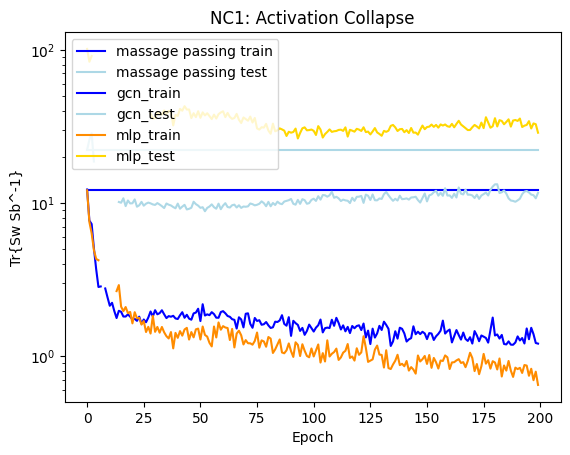

In [52]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.semilogy(range(200), [gcn_train_imb.Sw_invSb[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test_imb.Sw_invSb[0]] * 200, label='massage passing test', color='lightblue')
plt.semilogy(range(200), gcn_train_imb.Sw_invSb, label='gcn_train', color='blue')
plt.semilogy(range(200), gcn_test_imb.Sw_invSb, label='gcn_test', color='lightblue')
plt.semilogy(range(200), mlp_train_imb.Sw_invSb, label='mlp_train', color='darkorange')
plt.semilogy(range(200), mlp_test_imb.Sw_invSb, label='mlp_test', color='gold')
# plt.legend(['train', 'valid'])
plt.xlabel('Epoch')
plt.ylabel('Tr{Sw Sb^-1}')
plt.title('NC1: Activation Collapse')
plt.legend()

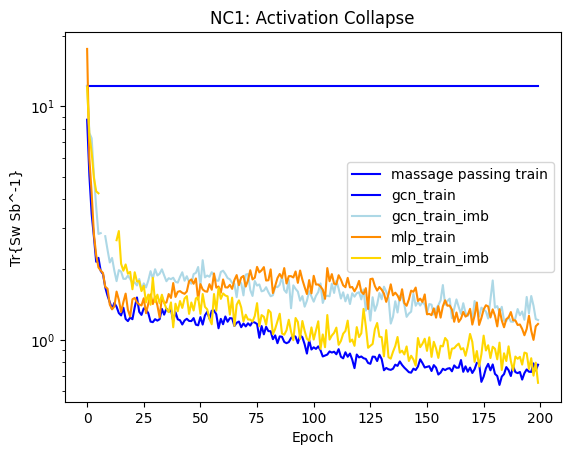

In [53]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.semilogy(range(200), [gcn_train_imb.Sw_invSb[0]] * 200, label='massage passing train', color='blue')
# plt.semilogy(range(200), [gcn_test_imb.Sw_invSb[0]] * 200, label='massage passing test', color='lightblue')
plt.semilogy(range(200), gcn_train.Sw_invSb, label='gcn_train', color='blue')
plt.semilogy(range(200), gcn_train_imb.Sw_invSb, label='gcn_train_imb', color='lightblue')
plt.semilogy(range(200), mlp_train.Sw_invSb, label='mlp_train', color='darkorange')
plt.semilogy(range(200), mlp_train_imb.Sw_invSb, label='mlp_train_imb', color='gold')
# plt.legend(['train', 'valid'])
plt.xlabel('Epoch')
plt.ylabel('Tr{Sw Sb^-1}')
plt.title('NC1: Activation Collapse')
plt.legend()

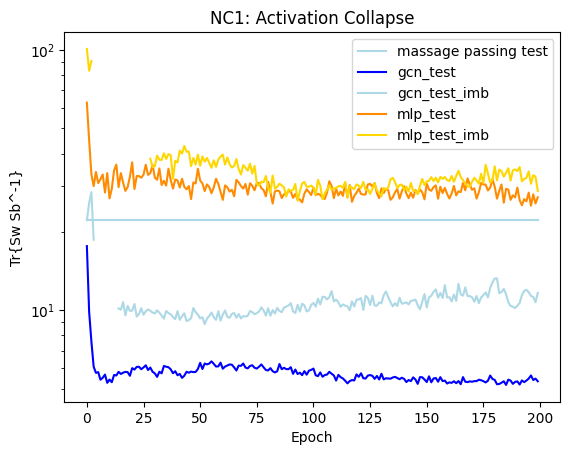

In [56]:
plt.figure(1)
# plt.semilogy(range(200), [gcn_train_imb.Sw_invSb[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test_imb.Sw_invSb[0]] * 200, label='massage passing test', color='lightblue')
plt.semilogy(range(200), gcn_test.Sw_invSb, label='gcn_test', color='blue')
plt.semilogy(range(200), gcn_test_imb.Sw_invSb, label='gcn_test_imb', color='lightblue')
plt.semilogy(range(200), mlp_test.Sw_invSb, label='mlp_test', color='darkorange')
plt.semilogy(range(200), mlp_test_imb.Sw_invSb, label='mlp_test_imb', color='gold')
# plt.legend(['train', 'valid'])
plt.xlabel('Epoch')
plt.ylabel('Tr{Sw Sb^-1}')
plt.title('NC1: Activation Collapse')
plt.legend()

Text(0.5, 1.0, 'NC1: Activation Collapse')

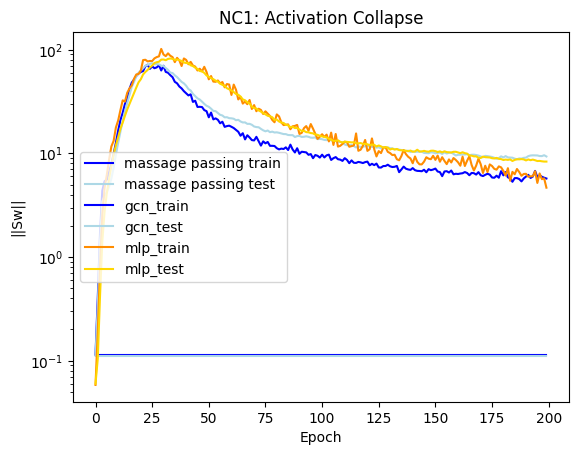

In [57]:
plt.figure(2)
plt.semilogy(range(200), [gcn_train_imb.tr_Sw[0]] * 200, label='massage passing train', color='blue')
plt.semilogy(range(200), [gcn_test_imb.tr_Sw[0]] * 200, label='massage passing test', color='lightblue')
plt.plot(range(200), gcn_train_imb.tr_Sw, label='gcn_train', color='blue')
plt.plot(range(200), gcn_test_imb.tr_Sw, label='gcn_test', color='lightblue')
plt.plot(range(200), mlp_train_imb.tr_Sw, label='mlp_train', color='darkorange')
plt.plot(range(200), mlp_test_imb.tr_Sw, label='mlp_test', color='gold')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('||Sw||')
plt.title('NC1: Activation Collapse')

Text(0.5, 1.0, 'NC2: Maximal Equiangularity')

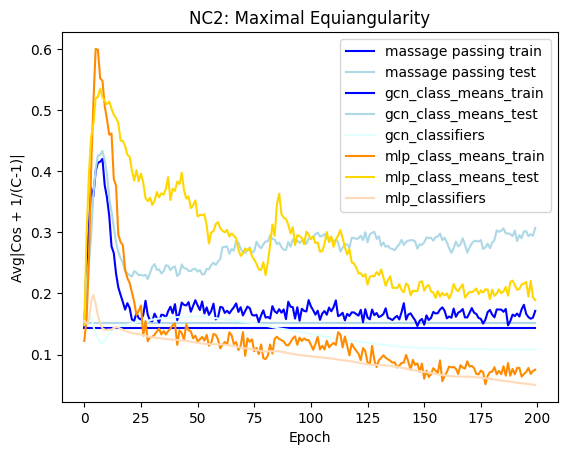

In [59]:
plt.figure(5)
plt.plot(range(200), [gcn_train_imb.cos_M[0]] * 200, label='massage passing train', color='blue')
plt.plot(range(200), [gcn_test_imb.cos_M[0]] * 200, label='massage passing test', color='lightblue')
plt.plot(range(200), gcn_train_imb.cos_M, label='gcn_class_means_train', color='blue')
plt.plot(range(200), gcn_test_imb.cos_M, label='gcn_class_means_test', color='lightblue')
plt.plot(range(200), gcn_train_imb.cos_W, label='gcn_classifiers', color='lightcyan')
plt.plot(range(200), mlp_train_imb.cos_M, label='mlp_class_means_train', color='darkorange')
plt.plot(range(200), mlp_test_imb.cos_M, label='mlp_class_means_test', color='gold')
plt.plot(range(200), mlp_train_imb.cos_W, label='mlp_classifiers', color='peachpuff')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Avg|Cos + 1/(C-1)|')
plt.title('NC2: Maximal Equiangularity')
### -1/7-1 = -0.16667

Text(0.5, 1.0, 'NC2: Maximal Equiangularity')

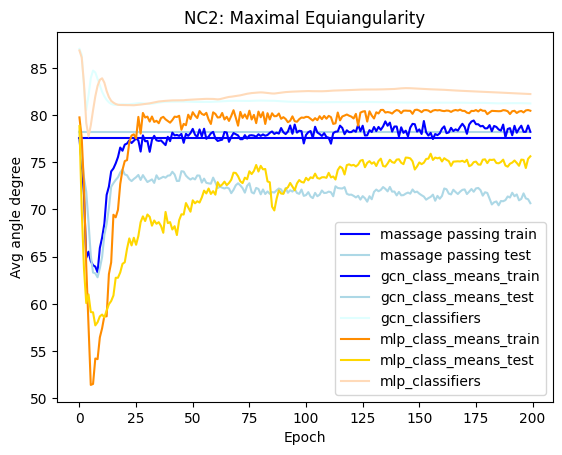

In [61]:
plt.figure(5)
plt.plot(range(200), [gcn_train_imb.degree_M[0]] * 200, label='massage passing train', color='blue')
plt.plot(range(200), [gcn_test_imb.degree_M[0]] * 200, label='massage passing test', color='lightblue')
plt.plot(range(200), gcn_train_imb.degree_M, label='gcn_class_means_train', color='blue')
plt.plot(range(200), gcn_test_imb.degree_M, label='gcn_class_means_test', color='lightblue')
plt.plot(range(200), gcn_train_imb.degree_W, label='gcn_classifiers', color='lightcyan')
plt.plot(range(200), mlp_train_imb.degree_M, label='mlp_class_means_train', color='darkorange')
plt.plot(range(200), mlp_test_imb.degree_M, label='mlp_class_means_test', color='gold')
plt.plot(range(200), mlp_train_imb.degree_W, label='mlp_classifiers', color='peachpuff')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Avg angle degree')
plt.title('NC2: Maximal Equiangularity')